# 1. Camera Calibration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline

### Display Chess Board Images for Calibration

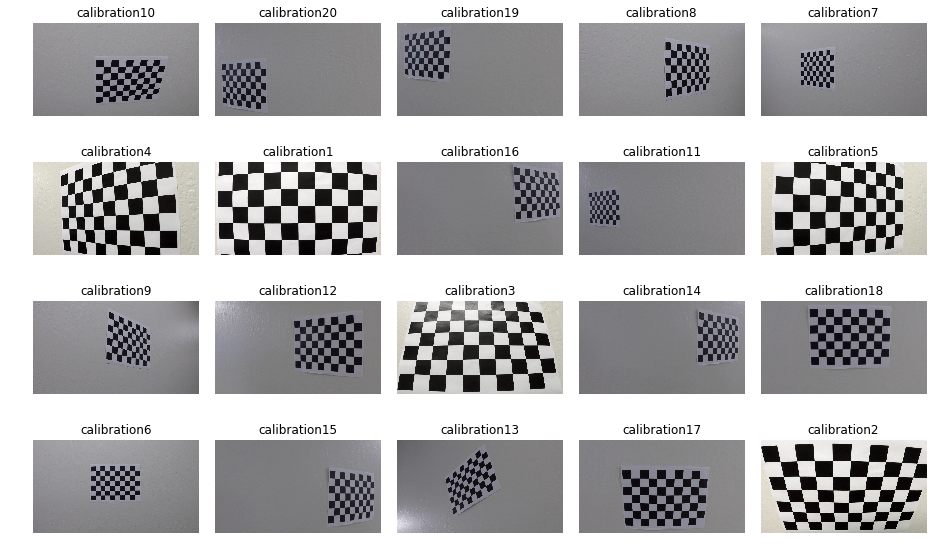

In [2]:
fig, axes = plt.subplots(4, 5, figsize=(16,10))
axes = axes.ravel()
fig.subplots_adjust(hspace=0.1, wspace=0.1)

path = './camera_cal/'
img_paths = glob.glob(path + '*.jpg')
for idx in range(len(img_paths)):
    img = cv2.imread(img_paths[idx])
    axes[idx].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    axes[idx].set_title(img_paths[idx].split('/')[-1].split('.')[0])
    axes[idx].axis('off')

### Find and Draw Corners

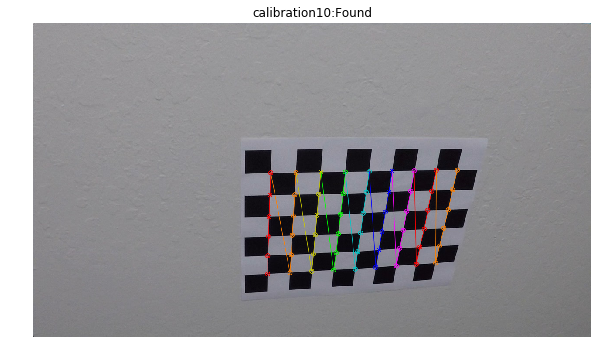

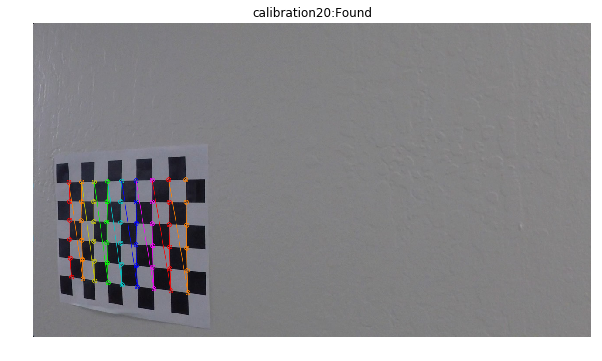

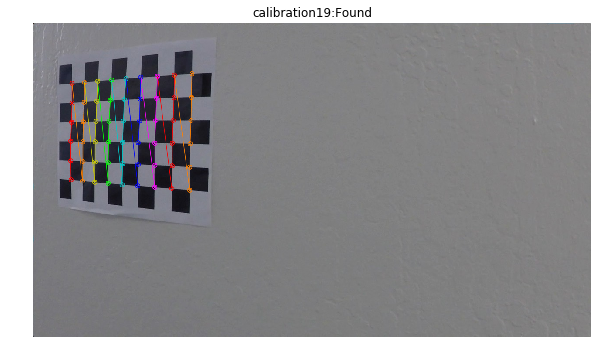

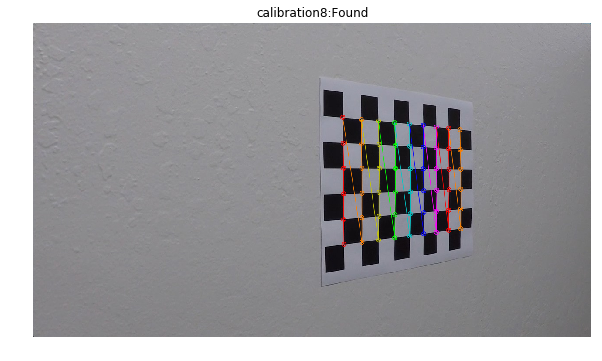

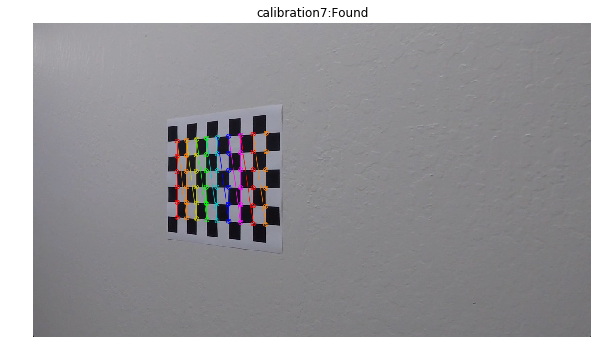

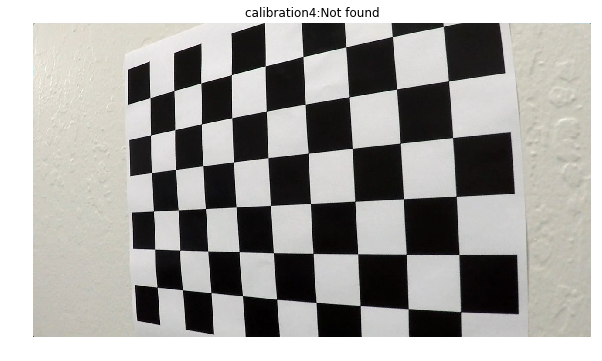

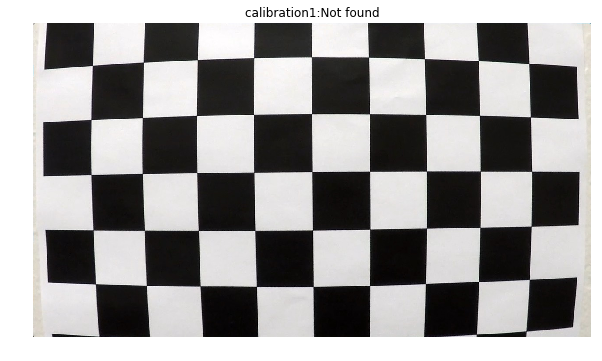

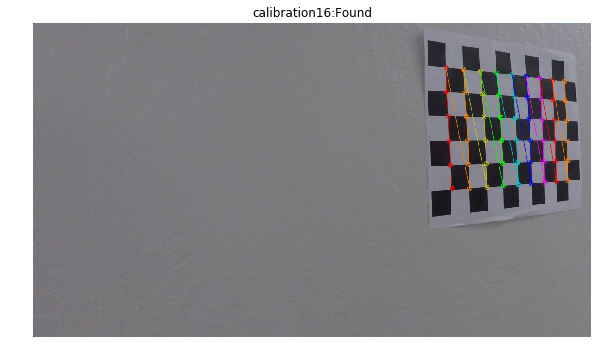

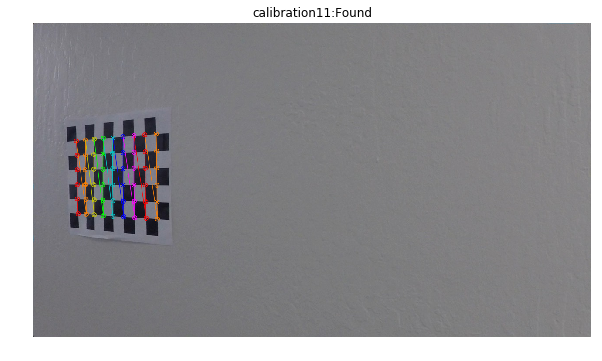

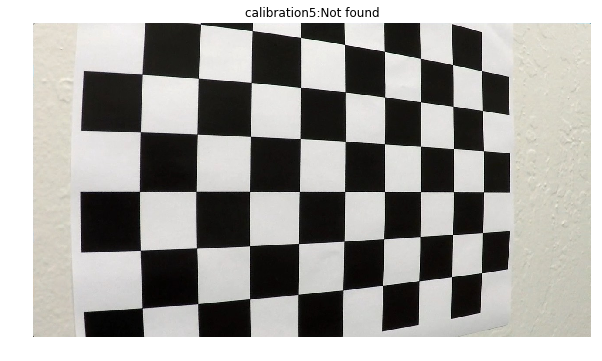

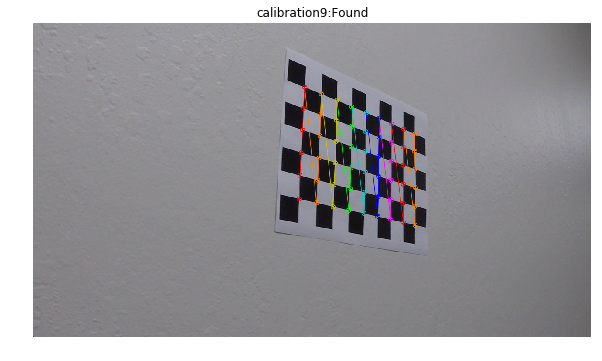

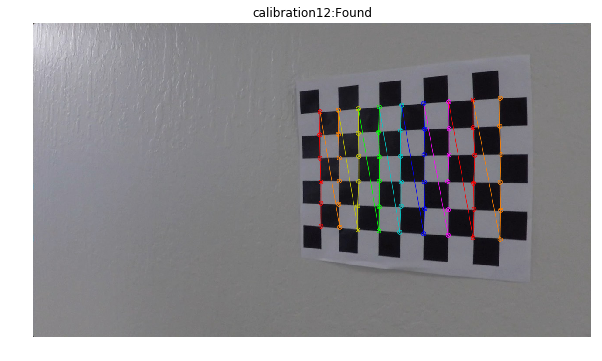

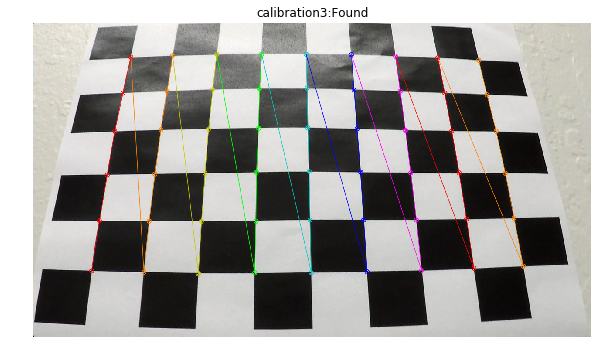

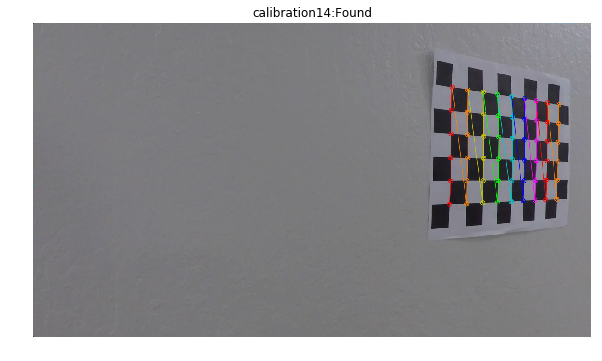

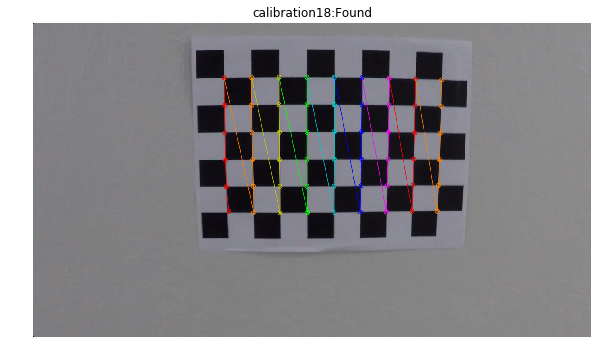

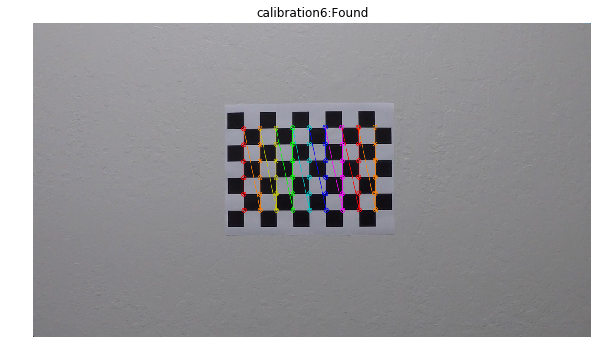

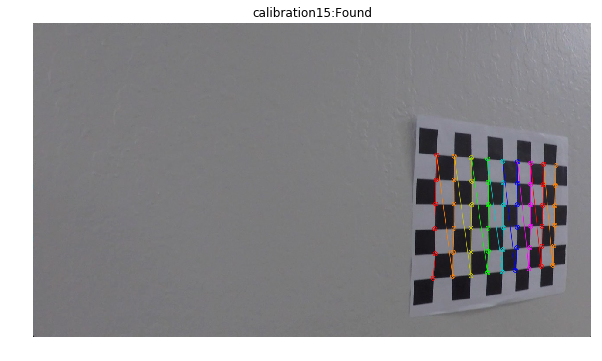

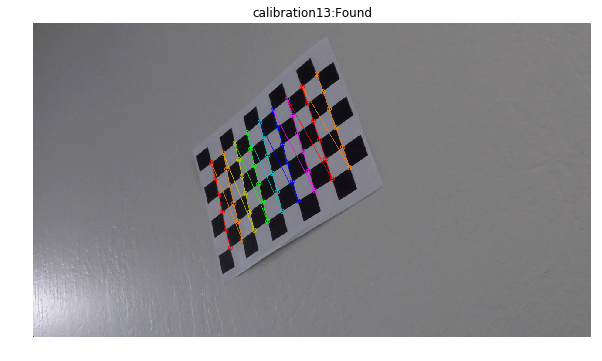

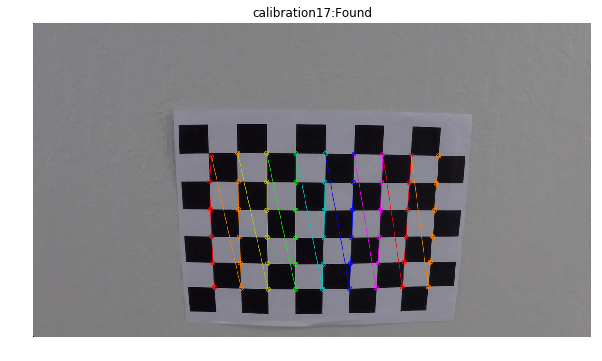

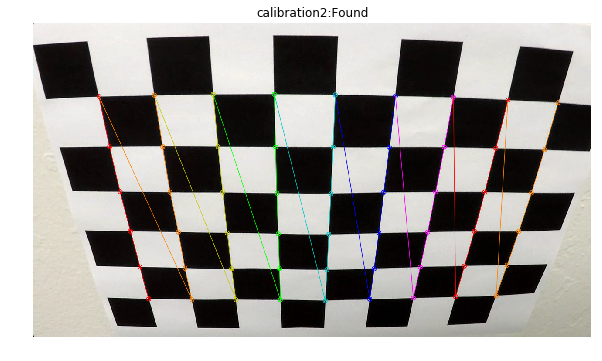

In [3]:
#### prepare object points, like (0,0,0), (1,0,0), (2,0,0)
objp = np.zeros((9*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:6, 0:9].T.reshape(-1, 2)

#### arrays to store object points and image points 
objpoints = [] #3D
imgpoints = [] #2D

for idx in range(len(img_paths)):
    img = cv2.imread(img_paths[idx])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #### find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (6, 9), None)

    #### if found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        #### draw and display the corners
        drawn_img = cv2.drawChessboardCorners(img, (6, 9), corners, ret)
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(drawn_img, cv2.COLOR_BGR2RGB))
        plt.title(img_paths[idx].split('/')[-1].split('.')[0] + ':' +'Found')
        plt.axis('off')
    else:
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(img_paths[idx].split('/')[-1].split('.')[0] + ':' + 'Not found')
        plt.axis('off')

### Calibrate Camera and Undistort 

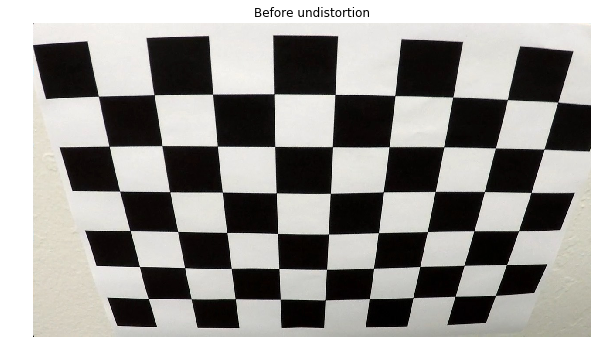

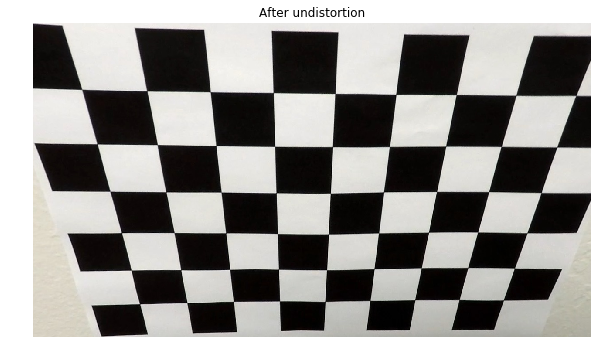

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#### undistort
img_test = cv2.imread('./camera_cal/calibration2.jpg')
dst_test = cv2.undistort(img_test, mtx, dist, None, mtx)
#### display the image before and after undistort
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
plt.title('Before undistortion')
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(dst_test, cv2.COLOR_BGR2RGB))
plt.title('After undistortion')
plt.axis('off')
plt.show()

# 2. Perspective Transform

### Display Test Images

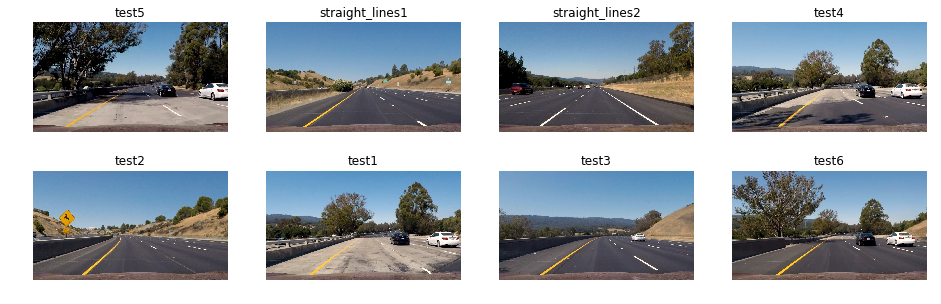

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(16, 5))
axes = axes.ravel()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

test_image_paths = glob.glob('./test_images/*.jpg')
for idx in range(len(test_image_paths)):
    test_image = cv2.imread(test_image_paths[idx])
    
    axes[idx].imshow(cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB))
    axes[idx].set_title(test_image_paths[idx].split('/')[-1].split('.')[0])
    axes[idx].axis('off')

### Transform After Undistortion

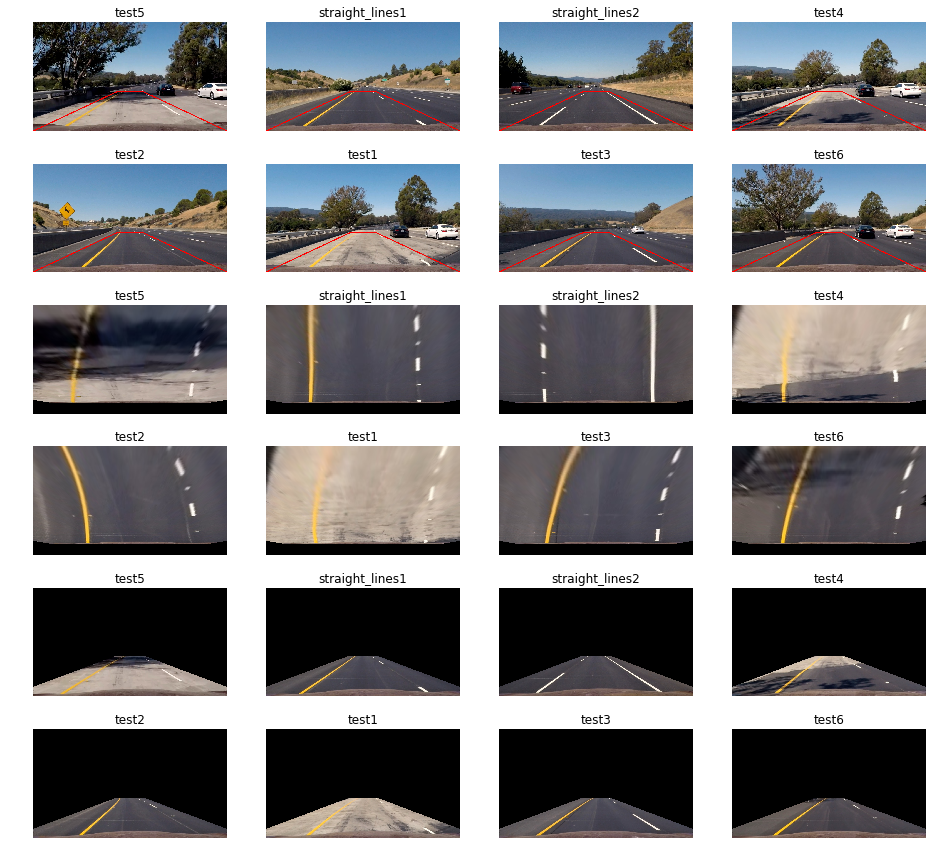

In [6]:
fig, axes = plt.subplots(6, 4, figsize=(16, 15))
axes = axes.ravel()
fig.subplots_adjust(hspace=0.3, wspace=0.2)

test_image_paths = glob.glob('./test_images/*.jpg')
for idx in range(len(test_image_paths)):
    test_image = cv2.imread(test_image_paths[idx])
    
    #### Undistortion
    test_dst = cv2.undistort(test_image, mtx, dist, None, mtx)
    #### Calculate transform matrix
    img_size = (test_image.shape[1], test_image.shape[0])
    
    pst1 = np.float32([(0, 720), (553, 460),(728, 460), (1280, 720)])
    pst2 = np.float32([(img_size[0]*0.1, img_size[1]*0.9), (img_size[0]*0.1, img_size[1]*0.1),
                       (img_size[0]*0.9, img_size[1]*0.1), (img_size[0]*0.9, img_size[1]*0.9)])
    M = cv2.getPerspectiveTransform(pst1, pst2)
    Minv = cv2.getPerspectiveTransform(pst2, pst1)
    #### Transform undistorted image
    warped = cv2.warpPerspective(test_dst, M, (img_size[0], img_size[1]))
    unwarped = cv2.warpPerspective(warped, Minv, (img_size[0], img_size[1]))
    
    
    #### Display chosen area
    copy = np.copy(test_image)
    cv2.line(copy, (0, 720), (553, 460), (0,0,255), 6)
    cv2.line(copy, (553, 460), (728, 460), (0,0,255), 6)
    cv2.line(copy, (728, 460), (1280, 720), (0,0,255), 6)
    axes[idx].imshow(cv2.cvtColor(copy, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(test_image_paths[idx].split('/')[-1].split('.')[0])
    axes[idx].axis('off')
    #### Display the transform result
    axes[idx+8].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    axes[idx+8].set_title(test_image_paths[idx].split('/')[-1].split('.')[0])
    axes[idx+8].axis('off')
    #### Display the inverse transform result
    axes[idx+16].imshow(cv2.cvtColor(unwarped, cv2.COLOR_BGR2RGB))
    axes[idx+16].set_title(test_image_paths[idx].split('/')[-1].split('.')[0])
    axes[idx+16].axis('off')
   

# 3. Color and Grandient Threshold

### Color Threshold

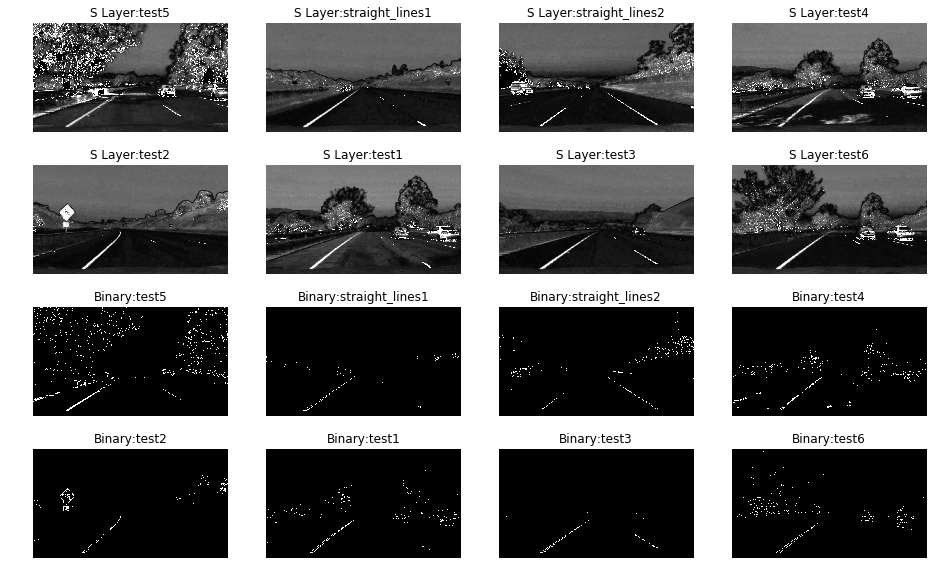

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(16, 10))
axes = axes.ravel()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

test_image_paths = glob.glob('./test_images/*.jpg')
for idx in range(len(test_image_paths)):
    test_image = cv2.imread(test_image_paths[idx])
    
    #### Convert color space into HLS
    hls = cv2.cvtColor(test_image, cv2.COLOR_BGR2HLS)
    #### Extract S layer
    S = hls[:,:,2]
    #### Get binary image by specific threshold
    threshold = (160, 245)
    binary = np.zeros_like(S)
    binary[(S > threshold[0]) & (S <= threshold[1])] = 1
    #### Display the result
    axes[idx].imshow(S, cmap='gray')
    axes[idx].set_title('S Layer:' + test_image_paths[idx].split('/')[-1].split('.')[0])
    axes[idx].axis('off')
    axes[idx+8].imshow(binary, cmap='gray')
    axes[idx+8].set_title('Binary:' + test_image_paths[idx].split('/')[-1].split('.')[0])
    axes[idx+8].axis('off')

### Grandient Threshold

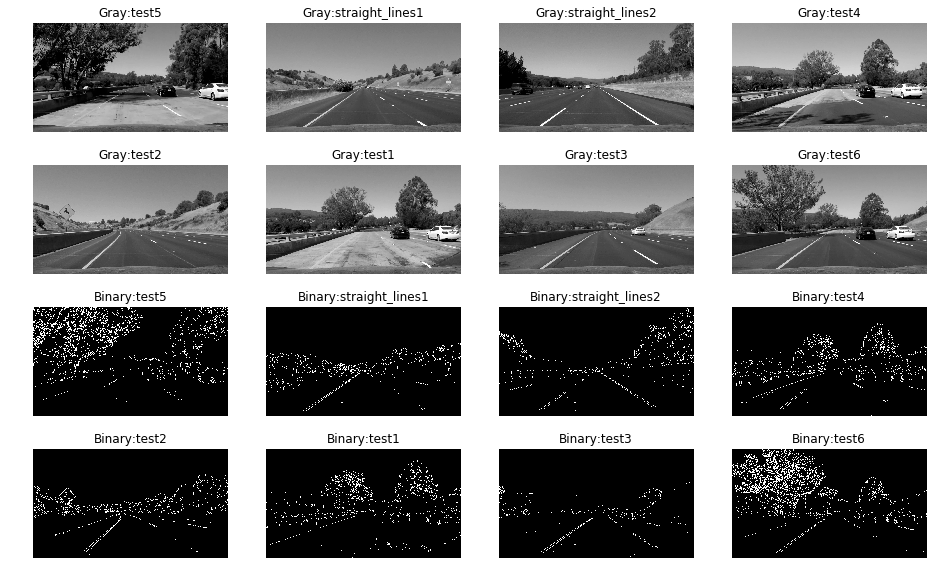

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(16, 10))
axes = axes.ravel()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

test_image_paths = glob.glob('./test_images/*.jpg')
for idx in range(len(test_image_paths)):
    test_image = cv2.imread(test_image_paths[idx])
    
    #### Convert color space into gray
    gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    #### Calculate the derivative of x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    #### Absolute value
    abs_sobelx = np.absolute(sobelx)
    #### scaled
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #### Get binary image by specific threshold
    threshold = (30, 100)
    binary = np.zeros_like(S)
    binary[(scaled_sobelx >= threshold[0]) & (scaled_sobelx <= threshold[1])] = 1
    #### Display the result
    axes[idx].imshow(gray, cmap='gray')
    axes[idx].set_title('Gray:' + test_image_paths[idx].split('/')[-1].split('.')[0])
    axes[idx].axis('off')
    axes[idx+8].imshow(binary, cmap='gray')
    axes[idx+8].set_title('Binary:' + test_image_paths[idx].split('/')[-1].split('.')[0])
    axes[idx+8].axis('off')

### Combining Color and Grandient Threshold

Implemented in Pipeline.
The Combining makes the approch more robust.

# 4. Sliding Window

In [9]:
def slide_window(binary_warped, nwindows=9, margin=100, minpix=50):    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[360:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, ploty, left_fitx, right_fitx

# 5. Pipeline

Choose 'test5' as the pipeline test image, which is a hard one to detect lane lines, so it could bring me a better performance of this approch on video test.

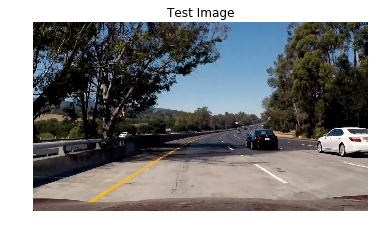

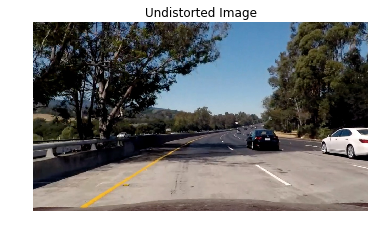

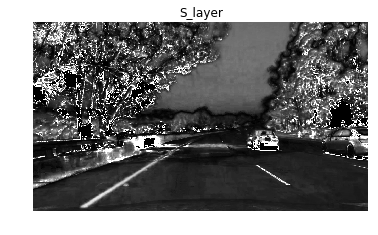

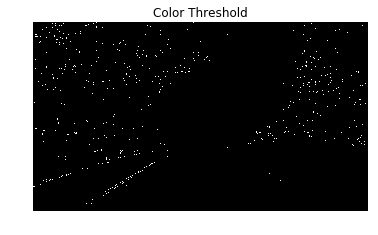

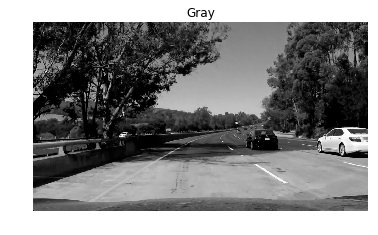

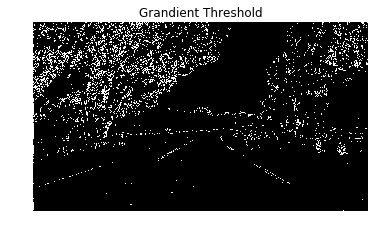

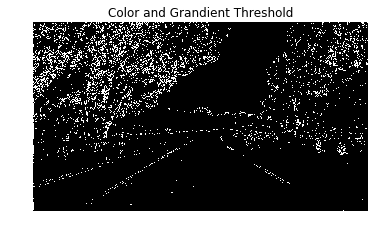

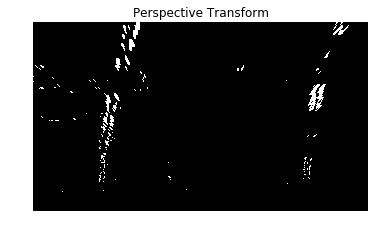

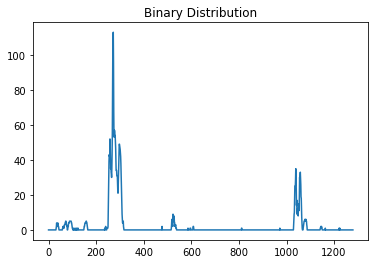

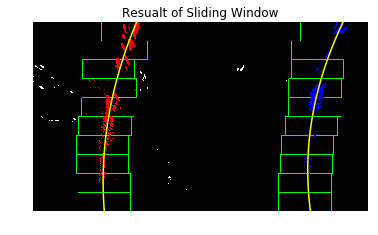

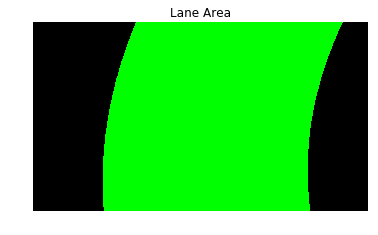

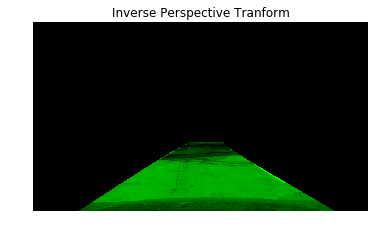

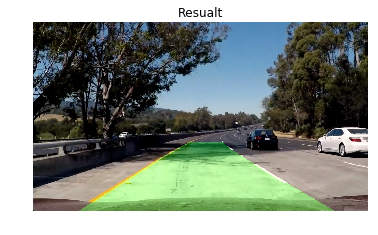

In [10]:
#### Read image
pip_img = cv2.imread('./test_images/test5.jpg')
plt.imshow(cv2.cvtColor(pip_img, cv2.COLOR_BGR2RGB))
plt.title('Test Image')
plt.axis('off')
plt.show()
#### Undistort image
undistorted_img = cv2.undistort(pip_img, mtx, dist, None, mtx)
plt.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')
plt.axis('off')
plt.show()
#### Color and Grandient threshold
color_thres = (175, 190)
hls_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2HLS)
s_layer = hls_img[:,:,2]
plt.imshow(s_layer, cmap='gray')
plt.title('S_layer')
plt.axis('off')
plt.show()
binary_img = np.zeros_like(s_layer)
binary_img[(s_layer > color_thres[0])&(s_layer <= color_thres[1])] = 1
plt.imshow(binary_img, cmap='gray')
plt.title('Color Threshold')
plt.axis('off')
plt.show()
#### Combine with grandient threshold
grand_thres = (30, 90)
gray = cv2.cvtColor(pip_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.title('Gray')
plt.axis('off')
plt.show()
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobelx)
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
sobel_img = np.zeros_like(binary_img)
sobel_img[(scaled_sobelx >= grand_thres[0])&(scaled_sobelx <= grand_thres[1])] = 1
plt.imshow(sobel_img, cmap='gray')
plt.title('Grandient Threshold')
plt.axis('off')
plt.show()
binary_img[(scaled_sobelx >= grand_thres[0])&(scaled_sobelx <= grand_thres[1])] = 1
plt.imshow(binary_img, cmap='gray')
plt.title('Color and Grandient Threshold')
plt.axis('off')
plt.show()
#### Perspective Transform
img_size = (gray.shape[1], gray.shape[0])
pst1 = np.float32([(0, 720), (553, 460),(728, 460), (1280, 720)])
pst2 = np.float32([(img_size[0]*0.1, img_size[1]*0.9), (img_size[0]*0.1, img_size[1]*0.1),
                   (img_size[0]*0.9, img_size[1]*0.1), (img_size[0]*0.9, img_size[1]*0.9)])
M = cv2.getPerspectiveTransform(pst1, pst2)
warped_img = cv2.warpPerspective(binary_img, M, (img_size[0], img_size[1]))
plt.imshow(warped_img, cmap='gray')
plt.title('Perspective Transform')
plt.axis('off')
plt.show()
x_sum = np.sum(warped_img[360:,:], axis=0)
plt.plot(x_sum)
plt.title('Binary Distribution')
plt.show()
#### Slide window
out_img, ploty, left_fitx, right_fitx = slide_window(warped_img, nwindows=10, margin=100, minpix=30)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Resualt of Sliding Window')
plt.axis('off')
plt.show()
#### Draw lane lines
mask = np.zeros_like(out_img)
left_pts = np.array([np.transpose(np.vstack((left_fitx,ploty)))])
right_pts = np.array([np.flipud(np.transpose(np.vstack((right_fitx,ploty))))])
lane_area = np.hstack((left_pts,right_pts))
cv2.fillPoly(mask,np.int_([lane_area]),(0,255,0))
plt.imshow(mask)
plt.title('Lane Area')
plt.axis('off')
plt.show()
Minv = cv2.getPerspectiveTransform(pst2, pst1)
unwarped_img = cv2.warpPerspective(mask, Minv, (img_size[0], img_size[1]))
res_img = cv2.bitwise_and(unwarped_img, pip_img)
plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))
plt.title('Inverse Perspective Tranform')
plt.axis('off')
plt.show()
result = cv2.addWeighted(cv2.cvtColor(pip_img, cv2.COLOR_BGR2RGB), 1, unwarped_img, 0.3, 0)
plt.title('Resualt')
plt.axis('off')
plt.imshow(result)
plt.show()

# 6. Test on Videos

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    ### Undistort image
    undistorted_img = cv2.undistort(image, mtx, dist, None, mtx)
    #### Color and Grandient threshold
    color_thres = (175, 190)
    hls_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2HLS)
    s_layer = hls_img[:,:,2]
    binary_img = np.zeros_like(s_layer)
    binary_img[(s_layer > color_thres[0])&(s_layer <= color_thres[1])] = 1
    #### Combine with grandient threshold
    grand_thres = (25, 130)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    binary_img[(scaled_sobelx >= grand_thres[0])&(scaled_sobelx <= grand_thres[1])] = 1
    #### Perspective Transform
    img_size = (gray.shape[1], gray.shape[0])
    pst1 = np.float32([(0, 720), (553, 460),(728, 460), (1280, 720)])
    pst2 = np.float32([(img_size[0]*0.1, img_size[1]*0.9), (img_size[0]*0.1, img_size[1]*0.1),
                       (img_size[0]*0.9, img_size[1]*0.1), (img_size[0]*0.9, img_size[1]*0.9)])
    M = cv2.getPerspectiveTransform(pst1, pst2)
    warped_img = cv2.warpPerspective(binary_img, M, (img_size[0], img_size[1]))
    x_sum = np.sum(warped_img[360:,:], axis=0)
    #### Slide window
    out_img, ploty, left_fitx, right_fitx = slide_window(warped_img, nwindows=12, margin=60, minpix=50)
    #### Draw lane lines
    mask = np.zeros_like(out_img)
    left_pts = np.array([np.transpose(np.vstack((left_fitx,ploty)))])
    right_pts = np.array([np.flipud(np.transpose(np.vstack((right_fitx,ploty))))])
    lane_area = np.hstack((left_pts,right_pts))
    cv2.fillPoly(mask,np.int_([lane_area]),(0,255,0))
    Minv = cv2.getPerspectiveTransform(pst2, pst1)
    unwarped_img = cv2.warpPerspective(mask, Minv, (img_size[0], img_size[1]))
    res_img = cv2.bitwise_and(unwarped_img, pip_img)
    result = cv2.addWeighted(image, 1, unwarped_img, 0.3, 0)
    return result

In [13]:
project_output = './output_videos/project_video.mp4'
clip1 = VideoFileClip("./test_videos/project_video.mp4")
project_clip = clip1.fl_image(process_image) 
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [02:41<00:00,  7.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

CPU times: user 5min 21s, sys: 10.8 s, total: 5min 32s
Wall time: 2min 43s


In [14]:
challenge_output = './output_videos/challenge_video.mp4'
clip2 = VideoFileClip("./test_videos/challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image) 
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/challenge_video.mp4
[MoviePy] Writing video ./output_videos/challenge_video.mp4


100%|██████████| 485/485 [00:59<00:00,  8.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/challenge_video.mp4 

CPU times: user 1min 57s, sys: 3.8 s, total: 2min 1s
Wall time: 1min


In [15]:
harder_challenge_output = './output_videos/harder_challenge_video.mp4'
clip3 = VideoFileClip("./test_videos/harder_challenge_video.mp4")
harder_challenge_clip = clip3.fl_image(process_image)
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/harder_challenge_video.mp4
[MoviePy] Writing video ./output_videos/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [02:48<00:00,  7.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/harder_challenge_video.mp4 

CPU times: user 5min 17s, sys: 11 s, total: 5min 28s
Wall time: 2min 50s
